# Homework 3: RNNs

In this assignment, you will use PyTorch and RNNs to solve two NLP problems:

1. Language identification
2. Language modeling

In the first, you will train a classifier to distinguish between English and Spanish sentences, and will essentially be creating a working version of the classifier demonstrated at the end of the PyTorch walkthrough from week 3's lecture. In the second you will train a neural language model to generate new British place names. For the second part, you will find Chapter 17 of the Goldberg text to be a useful reference.

**Note:** The networks that you will be training in this assignment are relatively simple, and the amounts of data are relatively small. That said, _**they will take time to train**_. On my laptop, the various networks take on the order of ≈5 minutes to train. Make sure not to wait until the last minute to do this assignment, as you will need to do a fair bit of experimentation and tinkering, and you won't want to find yourself running out of time.

## Part 0: Setup

In addition to Jupyter and `nose`, you will need to have `pytorch`, `numpy`, `pandas`, and Scikit-Learn installed for this assignment. As in HW2, most of your actual coding will take place in the `hw3_utils` module, and we will use unit tests to verify that things are working appropriately.

In [6]:
import nose
import torch
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sys
from importlib import reload

One other important thing to do is to set the random number generation seed. This will ensure deterministic results: each time you re-run the notebook, you should get the same random numbers. This is vital for ensuring reproducible results.

In [7]:
np.random.seed(42);
torch.manual_seed(42);

As before, let's check and see what versions of the libraries you've got installed:

In [8]:
print("My library versions:")
print(f"PyTorch: {torch.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"nose: {nose.__version__}")
print(f"sklearn: {sklearn.__version__}")

My library versions:
PyTorch: 1.0.0
Pandas: 0.23.0
Numpy: 1.16.0
matplotlib: 3.0.0
nose: 1.3.7
sklearn: 0.19.1


And we can run our tests as before:

In [9]:
! nosetests tests/test_environment.py

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


## Part 1: Preprocessing

### Vocabulary construction

As in the last part of HW2, we will be representing our input as numeric vectors. As such, we need a way to map tokens (characters, in the case of this assignment) to numeric indices. `hw3_utils.vocab` will contain functions to do this sort of transformation. The first such function will be `build_vocab`, and will take as input a corpus of sentences and as output produce mapping dictionaries. `vocab` includes special `BOS_SYM` and `EOS_SYM` symbols, to represent the beginning and end of string, respectively- make sure that the vocabularies that your implementation builds includes these characters.

* **Deliverable 1.1:** Complete the `vocab.build_vocab()` function
* **Test:** `nosetests tests/test_vocab.py:test_d1_1_char_vocab`

_Hint_: Remember that you can split a string into its sequence of characters using the `list` function. For _this_ assignment, you may ignore issues of Unicode decomposition and normalization, but in "real life" you would absolutely need to worry about such things!

In [10]:
from hw3_utils import vocab
reload(vocab);

In [11]:
tiny_corpus = ["This is a sentence.", "This is another sentence.", "Here is a third."]
c2i, i2c = vocab.build_vocab(tiny_corpus)

In [12]:
"T" == i2c[c2i["T"]]

True

In [13]:
!nosetests tests/test_vocab.py:test_d1_1_char_vocab

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### Sentence representation

In addition to a character inventory, we'll need a way to convert a sentence into a list of indicies. Ordinarily, one would need to worry about how to handle missing vocabulary entries (i.e., OOV words or symbols); _for this assignment_, we are ignoring this problem.

* **Deliverable 1.2:** Complete the `vocab.sentence_to_vector()` function
* **Test:** `nosetests tests/test_vocab.py:test_d1_2_sentence_vector`

In [14]:
reload(vocab);

In [15]:
s = "This is a sentence."
s_vec = vocab.sentence_to_vector(s, c2i)
print(s_vec)

[2, 11, 3, 13, 15, 3, 13, 15, 16, 15, 13, 5, 14, 8, 5, 14, 0, 5, 7]


In [16]:
[i2c[c] for c in s_vec]

['T',
 'h',
 'i',
 's',
 ' ',
 'i',
 's',
 ' ',
 'a',
 ' ',
 's',
 'e',
 'n',
 't',
 'e',
 'n',
 'c',
 'e',
 '.']

In [17]:
!nosetests tests/test_vocab.py:test_d1_2_sentence_vector

.
----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


PyTorch wants its input as `torch.Tensor` objects, not as Python `list`s, so we'll need to write one more short function to do that conversion. We'll want our tensors to be of size $(1,n)$, where $n$ is the length of the sentence in characters.

* **Deliverable 1.3:** Complete the `sentence_to_tensor()` function
* **Test:** `nosetests tests/test_vocab.py:test_d1_3_sentence_tensor`

In [18]:
reload(vocab);

In [19]:
s = "This is a sentence."
s_tens = vocab.sentence_to_tensor(s, c2i)
print(s_tens)
print(s_tens.size())

tensor([[ 2, 11,  3, 13, 15,  3, 13, 15, 16, 15, 13,  5, 14,  8,  5, 14,  0,  5,
          7]])
torch.Size([1, 19])


In [20]:
!nosetests tests/test_vocab.py:test_d1_3_sentence_tensor

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### Label lookup table

Just as we need to be able to represent characters as indices, we also need to be able to map _labels_ to indicies. The logic for this is very similar to what we did before for characters, but without the tokenization step.

* **Deliverable 1.4:** Complete the `vocab.build_label_vocab()` function
* **Test:** `nosetests tests/test_vocab.py:test_d1_4_label_vocab`

In [21]:
reload(vocab);

In [22]:
labels = ["eng","eng","spa","eng","deu"]
l2i, i2l = vocab.build_label_vocab(labels)

In [23]:
l2i['spa']

0

In [24]:
i2l[2]

'deu'

In [25]:
[l2i[l] for l in labels]

[1, 1, 0, 1, 2]

In [26]:
!nosetests tests/test_vocab.py:test_d1_4_label_vocab

.
----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


## Part 2: Language identification

Language identification is often one of the first steps of an NLP pipeline, and is a foundational task in NLP. _[Automatic Language Identification in Texts: A Survey](https://arxiv.org/pdf/1804.08186.pdf)_, by Jauhiainen et al., gives an excellent overview of the task and its rich history in our field, and I would _strongly_ recommend taking a few minutes to read it before beginning this part of the assignment.

Formally, we can craft language ID as a classification problem, given text sample $x$ and language $l \in L$, we want to find: 

$$ \operatorname*{argmax}_{l} P(l | x ) $$

This can be done in a variety of ways. One common (and well-performing) technique is to use trigram character frequencies, or other character-level features (writing system, etc.); some approaches rely on or incorporate word-level features. The difficulty of the task depends on a number of factors:

* How much training data one has from each language of interest (often an issue)
* How similar the languages are to one another (Spanish and Italian are more difficult to differentiate than are English and Arabic)
* How much ["code-switching"](https://en.wikipedia.org/wiki/Code-switching) is present in the language of interest

The last point is a major one: many texts of interest (tweets, etc.) contain a mix of languages, which can cause trouble both at the time of _training_ a language identification system as well as at the time of _inference_ (i.e., when you're actually trying to _use_ your system). The problem can be compounded by mixed writing systems: due to limitations of text-entry systems, users of some non-Latin scripts often will often write e.g. Arabic using English orthography. Names of places, brands, individuals, etc. can also cause script-level code switching. Fortunately, for this assignment, you will not need to worry about this issue.

We will be using [data](https://tatoeba.org/eng/downloads) from [Tatoeba](https://tatoeba.org), an online crowd-sourced language learning platform. Users collaboratively develop parallel corpora of sentences in a wide variety of languages. For this assignment, I have prepared two data sets based on Tatoeba's data:

* [sentences_bilingual.csv](./data/sentences_bilingual.csv): 10,000 random English and 10,000 random Spanish sentences
* [sentences_multilingual.csv](./data/sentences_multilingual.csv): 10,000 random sentences from each of English, Spanish, German, Italian, and French



## Getting Started

We'll begin with the bilingual (english/spanish) data:

In [27]:
bi_text = pd.read_csv("data/sentences_bilingual.csv")
bi_text.head()

,id,lang,sentence
0,6733426,eng,Tom wasn't able to change anything.
1,256835,eng,I saw the sights of Kyoto during my vacation.
2,1404674,eng,"And where are the aliens, the flying saucers, ..."
3,4833334,eng,Is the water in the Black Sea actually black?
4,7241028,eng,I know a lot of people who don't eat meat.


Step 1 is _always_ to look at your data. Verify how many entries we have, and of what languages:

In [28]:
print(f"Total entries: {len(bi_text)}")

Total entries: 20000


In [29]:
bi_text.groupby('lang').count()

,id,sentence
lang,,
eng,10000,10000
spa,10000,10000


Now, build a character inventory/vocabulary for our data:

In [30]:
c2i, i2c = vocab.build_vocab(bi_text.sentence.values)
l2i, i2l = vocab.build_label_vocab(bi_text.lang.values)

And now let's make a 80/20 training-test split:

In [31]:
from sklearn.model_selection import train_test_split
bi_text_train, bi_text_test = train_test_split(bi_text, test_size=0.2)

What is the resulting class distribution?

In [32]:
bi_text_train.groupby('lang').count()

,id,sentence
lang,,
eng,7981,7981
spa,8019,8019


In [33]:
bi_text_test.groupby('lang').count()

,id,sentence
lang,,
eng,2019,2019
spa,1981,1981


That's close enough to equal to be usable!

## Building a model

You should see that the data set is _balanced_ between two categories, English and Spanish.

The classification model you will build will first project sparse character representations to a dense learned embedding representation (as in Goldberg 4.8), feed the result into an LSTM, and then use the LSTM's output as the input into a softmax classifier to predict the language of the input. Note that we want to use the _final_ LSTM output for classification. More formally:

$$ \hat{y} = \operatorname*{softmax} \mathbf{o}^{(n)} $$

$$ \mathbf{o} = \mathbf{h} \mathbf{W}_o^T + b_o $$

$$ \mathbf{h} = LSTM(\mathbf{x})$$

$$ \mathbf{x}_{1:n} = \mathbf{E}[w_1], ... , \mathbf{E}[w_n] $$

Where $\mathbf{E}$ is an embedding layer, with its own learned weights, etc. We can use PyTorch's [`nn.Embedding`](https://pytorch.org/docs/stable/nn.html#embedding) layer class to take care of this part of our network- it takes as input a character index (just like the ones produced by our vocabulary function above). Similarly, we can use [`nn.LSTM`](https://pytorch.org/docs/stable/nn.html#lstm), [`nn.Linear`](https://pytorch.org/docs/stable/nn.html#linear), and [`nn.LogSoftmax`](https://pytorch.org/docs/stable/nn.html#logsoftmax) to create the rest of the layers.

This architecture has several hyperparameters that you must specify:

0. How many distinct characters do you need to represent ($n$)?
1. How many dimensions to use for embedding (representing) the characters ($e$)?
2. How many dimensions (hidden units) should the LSTM have ($h$)?
3. How many layers should the LSTM have?
3. How many output classes should the network have ($c$)?

The dimensionality of the layers of the network should then be: $n \times e$ for the embedding layer, $e \times h$ for the LSTM, and $h \times c$ for the output layer.

For this part of the assignment, I have done much of the work for you, and have provided a skeleton class with completed initialization functions. 

* **Deliverable 2.1:** Following the MLP example in the PyTorch walkthrough from Week 3, complete the `forward()` method in the `nn.Module` that is started for you in `hw3_utils.lang_id`. 
* **Test:** `nosetests tests/test_lang_id.py:test_d2_1_forward`



_Note_: typically, PyTorch networks are trained using minibatch training (see Goldberg 5.2.8); for the sake of keeping this assignment simple, we will not be using the standard PyTorch batching behaviors. Instead, we will be batching "manually"- calling `.backward()` and updating our parameters after a configurable interval. This will make training take a little bit longer, but will make _your_ code simpler. As such, the shape of the input will be slightly different than PyTorch expects by default. You may need to experiment a bit!

Also note that this is a "many-to-one" RNN architecture. Out of the box, `nn.LSTM` is set up for _many-to-many_ architectures where the input and output are synchronized- in other words, if you feed five time points _in_ to the LSTM (i.e., providing a $(1,5)$ input), you'll get a $(1,5)$ _output_ back. Since we only care about the _last_ timepoint's output for our classification problem, at some point you'll need to extract that value.

In [34]:
from hw3_utils import lang_id

Here, I am initializing the model with 10 embedding dimensions, 20 hidden dimensions, a single LSTM layer, and two output classes (_`eng`_ and _`spa`_):

In [35]:
reload(lang_id);
reload(vocab);

li = lang_id.LangID(
    input_vocab_n=len(c2i), 
    embedding_dims=10,
    hidden_dims=20,
    lstm_layers=1,
    output_class_n=2
)

Now that it's initialized, I can provide it with input and verify that the output is of the dimensionality I expect:

In [36]:
li(vocab.sentence_to_tensor("this is a sentence", c2i))

tensor([-0.7115, -0.6751], grad_fn=<SelectBackward>)

In [37]:
li(vocab.sentence_to_tensor("this is a sentence", c2i)).shape

torch.Size([2])

In [38]:
!nosetests tests/test_lang_id.py:test_d2_1_forward

.
----------------------------------------------------------------------
Ran 1 test in 0.093s

OK


**Tip**: I recommend building up the `forward()` method one layer at a time, at each step of the way verifying that the output you are seeing is what you expect.

That output is the raw log-probabilities associated with each class. This is not especially user-friendly, and makes evaluation a bit more difficult than we might care for. 

* **Deliverable 2.2:** Implement the `predict_one()` function in `hw3_utils.lang_id`.
* **Test:** `nosetests tests/test_lang_id.py:test_d2_2_predict_one`

In [39]:
reload(lang_id);

In [40]:
lang_id.predict_one(li, "this is a sentence", c2i, i2l)

'eng'

In [41]:
!nosetests tests/test_lang_id.py:test_d2_2_predict_one

.
----------------------------------------------------------------------
Ran 1 test in 0.081s

OK


## Training and evaluating model

Next, we need to train and evaluate the model. I have provided a `train_model()` function to do the training for this model, in `hw3_utils.lang_id`. This part of the assignment features fewer automated tests, and involves a little bit more thinking and writing.

In [113]:
reload(lang_id);

In [114]:
trained_model = lang_id.train_model(
    model=li, 
    n_epochs=1,
    training_data=bi_text_train,
    c2i=c2i, i2c=i2c,
    l2i=l2i, i2l=i2l
)

0/16000 average per-item loss: 0.0006888401694595814
1000/16000 average per-item loss: 0.2243460714817047
2000/16000 average per-item loss: 0.23720872402191162
3000/16000 average per-item loss: 0.23759843409061432
4000/16000 average per-item loss: 0.2039703130722046
5000/16000 average per-item loss: 0.23532581329345703
6000/16000 average per-item loss: 0.15993553400039673
7000/16000 average per-item loss: 0.2232811003923416
8000/16000 average per-item loss: 0.14585284888744354
9000/16000 average per-item loss: 0.15312175452709198
10000/16000 average per-item loss: 0.14668287336826324
11000/16000 average per-item loss: 0.13935953378677368
12000/16000 average per-item loss: 0.14572973549365997
13000/16000 average per-item loss: 0.16308416426181793
14000/16000 average per-item loss: 0.15902109444141388
15000/16000 average per-item loss: 0.1631738841533661


In [115]:
trained_model(vocab.sentence_to_tensor("this is a sentence", c2i))

tensor([-3.0065, -0.0507], grad_fn=<SelectBackward>)

In [116]:
trained_model(vocab.sentence_to_tensor("quien estas", c2i))

tensor([-0.0231, -3.7776], grad_fn=<SelectBackward>)

Now that we've got a trained model, it's time to evaluate its performance. 

* **Deliverable 2.3:** Complete the `eval_acc()` function in `hw3_utils.lang_id`. Note that PyTorch `Tensor` objects have an `argmax()` function!
* **Test:** `nosetests tests/test_lang_id.py:test_d2_3_eval_acc`

In [122]:
acc, y_hat = lang_id.eval_acc(trained_model, bi_text_test, c2i, i2c, l2i, i2l)
print(f"Accuracy: {acc}")

Accuracy: 0.9375


In [123]:
!nosetests tests/test_lang_id.py:test_d2_3_eval_acc

.
----------------------------------------------------------------------
Ran 1 test in 6.665s

OK


And what if we run this on a new, _untrained_ model?

In [124]:
untrained = lang_id.LangID(
    input_vocab_n=len(c2i), 
    embedding_dims=10,
    hidden_dims=20,
    lstm_layers=1,
    output_class_n=2
)

acc_untrained, y_hat_untrained = lang_id.eval_acc(untrained, bi_text_test, c2i, i2c, l2i, i2l)

print(f"Accuracy: {acc_untrained}")

Accuracy: 0.505


As expected, an untrained model gets approximately chance performance.

On our trained model, we were able to achieve ≈90% accuracy on held-out test data, which is very high accuracy! Let's investigate our hyperparameter settings: how small can we make our embedding and hidden dimensions before performance suffers?

* **Deliverable 2.4:** Turn both the embedding dimensions and the hidden dimensions _waaaaay_ down, to 2 each, and retrain/re-evaluate the model. Save your evaluation results to a CSV file named "deliverable_2.4.csv" with three columns: the sentence itself, the _true_ label, and the _predicted_ label. Also produce a text file named "deliverable_2.4.txt" containing the observed evaluation accuracy and an explanation of what you observe. Why is the number what it is?

In [125]:
li = lang_id.LangID(
    input_vocab_n=len(c2i), 
    embedding_dims=2,
    hidden_dims=2,
    lstm_layers=1,
    output_class_n=2
)
trained_model = lang_id.train_model(
    model=li, 
    n_epochs=1,
    training_data=bi_text_train,
    c2i=c2i, i2c=i2c,
    l2i=l2i, i2l=i2l
)

0/16000 average per-item loss: 0.008542902767658234
1000/16000 average per-item loss: 0.6969394683837891
2000/16000 average per-item loss: 0.6951727271080017
3000/16000 average per-item loss: 0.7027149796485901
4000/16000 average per-item loss: 0.6956417560577393
5000/16000 average per-item loss: 0.6855576038360596
6000/16000 average per-item loss: 0.6905822157859802
7000/16000 average per-item loss: 0.6951261758804321
8000/16000 average per-item loss: 0.6904613971710205
9000/16000 average per-item loss: 0.690335750579834
10000/16000 average per-item loss: 0.6891825795173645
11000/16000 average per-item loss: 0.688647449016571
12000/16000 average per-item loss: 0.69231116771698
13000/16000 average per-item loss: 0.681308925151825
14000/16000 average per-item loss: 0.6680842638015747
15000/16000 average per-item loss: 0.6672831773757935


In [93]:
acc, y_hat = lang_id.eval_acc(trained_model, bi_text_test, c2i, i2c, l2i, i2l)
print(f"Accuracy: {acc}")

NameError: name 'trained_model' is not defined

In [137]:
import csv


with open('deliverable_2.4.csv', 'a') as csvFile:
    writer = csv.writer(csvFile)
    for i,s in enumerate(bi_text_test.sentence.values):
        row = [s, bi_text_test.lang.values[i], y_hat[i]]
        writer.writerow(row)

csvFile.close()

### Extending to multinomial classification

Clearly, a simple LSTM classifier works very well for this binary classification problem, even for very low-dimensional networks. What if we try and do multi-class classification? Our model should, in theory, be adaptable to that case. How sensitive is it to our network dimensionality?

In [147]:
multi_text = pd.read_csv("data/sentences_multilingual.csv")
multi_text_train, multi_text_test = train_test_split(multi_text, test_size=0.2)

multi_text.groupby('lang').count()


,id,sentence
lang,,
deu,10000,10000
eng,10000,10000
fra,10000,10000
ita,10000,10000
spa,10000,10000


In [148]:
multi_text_train.groupby('lang').count()

,id,sentence
lang,,
deu,7984,7984
eng,7965,7965
fra,8026,8026
ita,8002,8002
spa,8023,8023


In [149]:
c2i, i2c = vocab.build_vocab(multi_text.sentence.values)
l2i, i2l = vocab.build_label_vocab(multi_text.lang.values)

In [141]:
multi_class = lang_id.LangID(
    input_vocab_n=len(c2i), 
    embedding_dims=10,
    hidden_dims=20,
    lstm_layers=1,
    output_class_n=5
)

lang_id.train_model(
    model=multi_class, 
    n_epochs=1,
    training_data=multi_text_train,
    c2i=c2i, i2c=i2c,
    l2i=l2i, i2l=i2l
);

print("done")

0/40000 average per-item loss: 0.015076127834618092
1000/40000 average per-item loss: 1.5986831188201904
2000/40000 average per-item loss: 1.6014474630355835
3000/40000 average per-item loss: 1.581262230873108
4000/40000 average per-item loss: 1.5677635669708252
5000/40000 average per-item loss: 1.5651962757110596
6000/40000 average per-item loss: 1.5561169385910034
7000/40000 average per-item loss: 1.5450067520141602
8000/40000 average per-item loss: 1.4866209030151367
9000/40000 average per-item loss: 1.5289950370788574
10000/40000 average per-item loss: 1.530856966972351
11000/40000 average per-item loss: 1.4655945301055908
12000/40000 average per-item loss: 1.4569896459579468
13000/40000 average per-item loss: 1.2953541278839111
14000/40000 average per-item loss: 1.295280933380127
15000/40000 average per-item loss: 1.3843365907669067
16000/40000 average per-item loss: 1.2826933860778809
17000/40000 average per-item loss: 1.1819465160369873
18000/40000 average per-item loss: 1.36246

Now that it's trained, let's evaluate it as before:

In [142]:
acc_multi, y_hat_multi = lang_id.eval_acc(multi_class, multi_text_test, c2i, i2c, l2i, i2l)

print(f"Accuracy: {acc_multi}")

Accuracy: 0.6542


For 5-way classification, a single accuracy number is less useful than it is for binary classification. Scikit-Learn has some helpful classes for evaluating classifiers:

In [97]:
from sklearn.metrics import classification_report, confusion_matrix

The `classification_report` function will give us a per-class breakdown of our performance:

In [144]:
y_multi = multi_text_test.lang.values
print(classification_report(y_multi, y_hat_multi))

             precision    recall  f1-score   support

        deu       0.76      0.78      0.77      2006
        eng       0.72      0.79      0.75      1976
        fra       0.68      0.64      0.66      2051
        ita       0.60      0.55      0.57      1988
        spa       0.50      0.51      0.51      1979

avg / total       0.65      0.65      0.65     10000



The `confusion_matrix` function will give us a raw confusion matrix; rows are "truth" and columns are "predictions".

In [145]:
cm = confusion_matrix(y_multi, y_hat_multi)
cm

array([[1558,  236,  167,   21,   24],
       [ 189, 1557,   72,   49,  109],
       [ 236,  143, 1309,   93,  270],
       [  31,   94,  148, 1099,  616],
       [  37,  121,  228,  574, 1019]])

The `lang_id` module has a method to make nicer-looking matrices:

In [146]:
reload(lang_id);

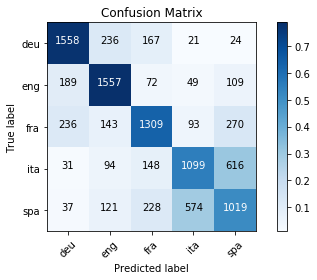

In [147]:
lang_id.pretty_conf_matrix(cm, ['deu','eng','fra','ita','spa'])

* **Deliverable 2.5:** Interpret these results. Why is our classifier performing better on some languages than on others? Put your analysis in a file named `deliverable_2.5.txt`.

From here, the rest of this section is up to you. Experiment with different numbers of embedding & hidden dimensions, hidden LSTM layers, etc., and see how high you can get your classification accuracy. Also try training for additional epochs. Does that help?

* **Deliverable 2.6:** Describe at least two additional models that you trained and evaluated, along with their overall and per-class accuracies. What seemed to help the most? Put your discussion in a file named `deliverable_2.6.txt`.

In [98]:
multi_class = lang_id.LangID(
    input_vocab_n=len(c2i), 
    embedding_dims=20,
    hidden_dims=20,
    lstm_layers=2,
    output_class_n=5
)

lang_id.train_model(
    model=multi_class, 
    n_epochs=2,
    training_data=multi_text_train,
    c2i=c2i, i2c=i2c,
    l2i=l2i, i2l=i2l
);

0/40000 average per-item loss: 0.017803587019443512
1000/40000 average per-item loss: 1.6176012754440308
2000/40000 average per-item loss: 1.6195448637008667
3000/40000 average per-item loss: 1.6094096899032593
4000/40000 average per-item loss: 1.5990208387374878
5000/40000 average per-item loss: 1.5748869180679321
6000/40000 average per-item loss: 1.5326803922653198
7000/40000 average per-item loss: 1.5294543504714966
8000/40000 average per-item loss: 1.471760869026184
9000/40000 average per-item loss: 1.3486030101776123
10000/40000 average per-item loss: 1.27962327003479
11000/40000 average per-item loss: 1.2249219417572021
12000/40000 average per-item loss: 1.2858517169952393
13000/40000 average per-item loss: 1.1225385665893555
14000/40000 average per-item loss: 1.0611099004745483
15000/40000 average per-item loss: 0.9737956523895264
16000/40000 average per-item loss: 0.9998188018798828
17000/40000 average per-item loss: 0.9984406232833862
18000/40000 average per-item loss: 0.95154

In [99]:
acc_multi, y_hat_multi = lang_id.eval_acc(multi_class, multi_text_test, c2i, i2c, l2i, i2l)

print(f"Accuracy: {acc_multi}")

Accuracy: 0.894


In [100]:
y_multi = multi_text_test.lang.values
print(classification_report(y_multi, y_hat_multi))

             precision    recall  f1-score   support

        deu       0.94      0.95      0.95      2035
        eng       0.91      0.94      0.92      1978
        fra       0.91      0.91      0.91      2021
        ita       0.89      0.80      0.84      1974
        spa       0.83      0.88      0.85      1992

avg / total       0.89      0.89      0.89     10000



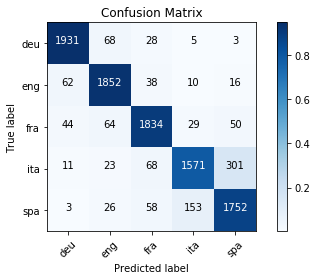

In [101]:
cm = confusion_matrix(y_multi, y_hat_multi)
reload(lang_id);
lang_id.pretty_conf_matrix(cm, ['deu','eng','fra','ita','spa'])

In [102]:
multi_class = lang_id.LangID(
    input_vocab_n=len(c2i), 
    embedding_dims=10,
    hidden_dims=10,
    lstm_layers=1,
    output_class_n=5
)

lang_id.train_model(
    model=multi_class, 
    n_epochs=1,
    training_data=multi_text_train,
    c2i=c2i, i2c=i2c,
    l2i=l2i, i2l=i2l
);

0/40000 average per-item loss: 0.016674639657139778
1000/40000 average per-item loss: 1.6203396320343018
2000/40000 average per-item loss: 1.6039543151855469
3000/40000 average per-item loss: 1.6101795434951782
4000/40000 average per-item loss: 1.6195019483566284
5000/40000 average per-item loss: 1.6125173568725586
6000/40000 average per-item loss: 1.5810378789901733
7000/40000 average per-item loss: 1.566371202468872
8000/40000 average per-item loss: 1.5594722032546997
9000/40000 average per-item loss: 1.526036262512207
10000/40000 average per-item loss: 1.5306261777877808
11000/40000 average per-item loss: 1.5281530618667603
12000/40000 average per-item loss: 1.4807748794555664
13000/40000 average per-item loss: 1.4732457399368286
14000/40000 average per-item loss: 1.4470728635787964
15000/40000 average per-item loss: 1.4309214353561401
16000/40000 average per-item loss: 1.4310083389282227
17000/40000 average per-item loss: 1.3167202472686768
18000/40000 average per-item loss: 1.3450

In [103]:
acc_multi, y_hat_multi = lang_id.eval_acc(multi_class, multi_text_test, c2i, i2c, l2i, i2l)

print(f"Accuracy: {acc_multi}")

Accuracy: 0.568


In [104]:
y_multi = multi_text_test.lang.values
print(classification_report(y_multi, y_hat_multi))

             precision    recall  f1-score   support

        deu       0.55      0.85      0.67      2035
        eng       0.44      0.13      0.20      1978
        fra       0.60      0.71      0.65      2021
        ita       0.58      0.79      0.67      1974
        spa       0.59      0.36      0.44      1992

avg / total       0.55      0.57      0.53     10000



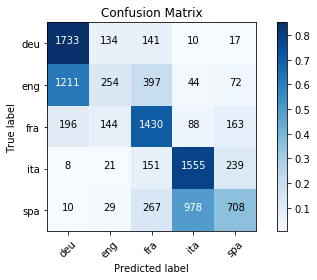

In [105]:
cm = confusion_matrix(y_multi, y_hat_multi)
reload(lang_id);
lang_id.pretty_conf_matrix(cm, ['deu','eng','fra','ita','spa'])

In [154]:
multi_class = lang_id.LangID(
    input_vocab_n=len(c2i), 
    embedding_dims=20,
    hidden_dims=20,
    lstm_layers=1,
    output_class_n=5
)

lang_id.train_model(
    model=multi_class, 
    n_epochs=5,
    training_data=multi_text_train,
    c2i=c2i, i2c=i2c,
    l2i=l2i, i2l=i2l
);

0/40000 average per-item loss: 0.0158828254789114
1000/40000 average per-item loss: 1.588904619216919
2000/40000 average per-item loss: 1.6086348295211792
3000/40000 average per-item loss: 1.5812290906906128
4000/40000 average per-item loss: 1.5546603202819824
5000/40000 average per-item loss: 1.5401180982589722
6000/40000 average per-item loss: 1.5042529106140137
7000/40000 average per-item loss: 1.506708025932312
8000/40000 average per-item loss: 1.4438737630844116
9000/40000 average per-item loss: 1.4441027641296387
10000/40000 average per-item loss: 1.345941185951233
11000/40000 average per-item loss: 1.351986050605774
12000/40000 average per-item loss: 1.344778299331665
13000/40000 average per-item loss: 1.3795744180679321
14000/40000 average per-item loss: 1.2552149295806885
15000/40000 average per-item loss: 1.1756713390350342
16000/40000 average per-item loss: 1.2751102447509766
17000/40000 average per-item loss: 1.0503590106964111
18000/40000 average per-item loss: 1.100914239

33000/40000 average per-item loss: 0.26792290806770325
34000/40000 average per-item loss: 0.2848656475543976
35000/40000 average per-item loss: 0.1681773066520691
36000/40000 average per-item loss: 0.23927387595176697
37000/40000 average per-item loss: 0.20704707503318787
38000/40000 average per-item loss: 0.23254165053367615
39000/40000 average per-item loss: 0.2612389028072357
0/40000 average per-item loss: 0.0043058632872998714
1000/40000 average per-item loss: 0.26192381978034973
2000/40000 average per-item loss: 0.24132369458675385
3000/40000 average per-item loss: 0.23484307527542114
4000/40000 average per-item loss: 0.15261101722717285
5000/40000 average per-item loss: 0.2978363037109375
6000/40000 average per-item loss: 0.296398788690567
7000/40000 average per-item loss: 0.22128215432167053
8000/40000 average per-item loss: 0.20676490664482117
9000/40000 average per-item loss: 0.24314190447330475
10000/40000 average per-item loss: 0.22396086156368256
11000/40000 average per-ite

In [155]:
acc_multi, y_hat_multi = lang_id.eval_acc(multi_class, multi_text_test, c2i, i2c, l2i, i2l)

print(f"Accuracy: {acc_multi}")

Accuracy: 0.9268


In [156]:
y_multi = multi_text_test.lang.values
print(classification_report(y_multi, y_hat_multi))

             precision    recall  f1-score   support

        deu       0.95      0.98      0.96      2016
        eng       0.97      0.92      0.94      2035
        fra       0.93      0.95      0.94      1974
        ita       0.84      0.97      0.90      1998
        spa       0.97      0.81      0.88      1977

avg / total       0.93      0.93      0.93     10000



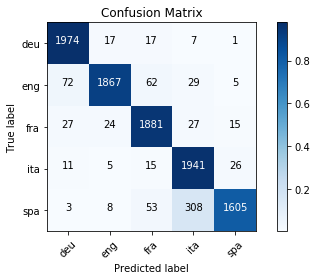

In [157]:
cm = confusion_matrix(y_multi, y_hat_multi)
reload(lang_id);
lang_id.pretty_conf_matrix(cm, ['deu','eng','fra','ita','spa'])

In [110]:
multi_class = lang_id.LangID(
    input_vocab_n=len(c2i), 
    embedding_dims=20,
    hidden_dims=20,
    lstm_layers=2,
    output_class_n=5
)

lang_id.train_model(
    model=multi_class, 
    n_epochs=1,
    training_data=multi_text_train,
    c2i=c2i, i2c=i2c,
    l2i=l2i, i2l=i2l
);

0/40000 average per-item loss: 0.017503399401903152
1000/40000 average per-item loss: 1.6128486394882202
2000/40000 average per-item loss: 1.6001707315444946
3000/40000 average per-item loss: 1.5954718589782715
4000/40000 average per-item loss: 1.5788264274597168
5000/40000 average per-item loss: 1.5570963621139526
6000/40000 average per-item loss: 1.5438754558563232
7000/40000 average per-item loss: 1.4608960151672363
8000/40000 average per-item loss: 1.4018139839172363
9000/40000 average per-item loss: 1.384448528289795
10000/40000 average per-item loss: 1.293208360671997
11000/40000 average per-item loss: 1.2316993474960327
12000/40000 average per-item loss: 1.2748445272445679
13000/40000 average per-item loss: 1.3174570798873901
14000/40000 average per-item loss: 1.1509307622909546
15000/40000 average per-item loss: 1.26630437374115
16000/40000 average per-item loss: 1.097721815109253
17000/40000 average per-item loss: 1.1390362977981567
18000/40000 average per-item loss: 1.2555518

In [111]:
acc_multi, y_hat_multi = lang_id.eval_acc(multi_class, multi_text_test, c2i, i2c, l2i, i2l)

print(f"Accuracy: {acc_multi}")

Accuracy: 0.746


In [112]:
y_multi = multi_text_test.lang.values
print(classification_report(y_multi, y_hat_multi))

             precision    recall  f1-score   support

        deu       0.87      0.94      0.91      2035
        eng       0.91      0.78      0.84      1978
        fra       0.77      0.92      0.84      2021
        ita       0.58      0.72      0.64      1974
        spa       0.59      0.37      0.45      1992

avg / total       0.74      0.75      0.74     10000



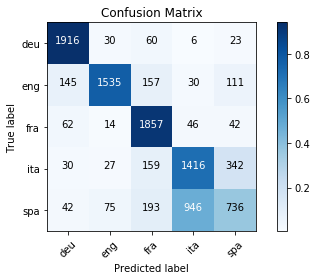

In [113]:
cm = confusion_matrix(y_multi, y_hat_multi)
reload(lang_id);
lang_id.pretty_conf_matrix(cm, ['deu','eng','fra','ita','spa'])

In [150]:
multi_class = lang_id.LangID(
    input_vocab_n=len(c2i), 
    embedding_dims=20,
    hidden_dims=24,
    lstm_layers=2,
    output_class_n=5
)

lang_id.train_model(
    model=multi_class, 
    n_epochs=3,
    training_data=multi_text_train,
    c2i=c2i, i2c=i2c,
    l2i=l2i, i2l=i2l
);

0/40000 average per-item loss: 0.016331946477293968
1000/40000 average per-item loss: 1.6144919395446777
2000/40000 average per-item loss: 1.5998574495315552
3000/40000 average per-item loss: 1.5849065780639648
4000/40000 average per-item loss: 1.5757333040237427
5000/40000 average per-item loss: 1.5408329963684082
6000/40000 average per-item loss: 1.4896377325057983
7000/40000 average per-item loss: 1.3099180459976196
8000/40000 average per-item loss: 1.2803066968917847
9000/40000 average per-item loss: 1.2747670412063599
10000/40000 average per-item loss: 1.087479591369629
11000/40000 average per-item loss: 1.1885241270065308
12000/40000 average per-item loss: 1.1698280572891235
13000/40000 average per-item loss: 0.9776292443275452
14000/40000 average per-item loss: 0.9017823934555054
15000/40000 average per-item loss: 1.0527554750442505
16000/40000 average per-item loss: 0.9936138987541199
17000/40000 average per-item loss: 0.9611386656761169
18000/40000 average per-item loss: 0.837

In [151]:
acc_multi, y_hat_multi = lang_id.eval_acc(multi_class, multi_text_test, c2i, i2c, l2i, i2l)

print(f"Accuracy: {acc_multi}")

Accuracy: 0.9232


In [152]:
y_multi = multi_text_test.lang.values
print(classification_report(y_multi, y_hat_multi))

             precision    recall  f1-score   support

        deu       0.98      0.95      0.96      2016
        eng       0.95      0.93      0.94      2035
        fra       0.94      0.93      0.94      1974
        ita       0.88      0.91      0.90      1998
        spa       0.87      0.89      0.88      1977

avg / total       0.92      0.92      0.92     10000



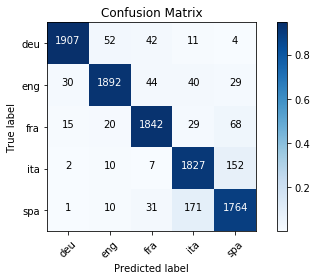

In [153]:
cm = confusion_matrix(y_multi, y_hat_multi)
reload(lang_id);
lang_id.pretty_conf_matrix(cm, ['deu','eng','fra','ita','spa'])

## Part 3: Language modeling

### Getting Started

In this part of the assignment, you will build and evaluate a simple LSTM character language model, and then _sample_ from it to generate new text mimicking the training data. The model you will build should follow the general structure outlined in Section 17.1 of the Goldberg text, and use the "teacher-forcing" training method outlined in 17.1.1.

$$ p(\mathbf{w}_n | \mathbf{w}_{1:n-1}) = \operatorname*{softmax} \mathbf{o}^{(n-1)} $$

$$ o = \mathbf{h} \mathbf{W}_o^T + b_o $$

$$ \mathbf{h} = LSTM(\mathbf{x})$$

$$ \mathbf{x}_{1:n-1} = \mathbf{E}[w_1], ... , \mathbf{E}[w_n-1] $$

For this part of the assignment, we will be working with a data set of British place names located in `data/towns_clean.txt`.

In [165]:
corpus = [l.strip() for l in open('data/towns_clean.txt')]
c2i, i2c = vocab.build_vocab(corpus)

for t in np.random.choice(corpus, size=10):
    print(t)

Pristacott
Ellington
Green Down
Lane End
Longdon on Tern
Cadham
Pennymoor
Rock
Cloatley
Kirkton


Your network, once trained, will learn to recognize British place names, and will be able to make up new ones.

* **Deliverable 3.1:** Implement the `__init__()`, and `forward()` functions in `hw3_utils.lm.NameGenerator`.
* **Test:** `nosetests tests/test_lm.py:test_d3_1_setup`

Once you've got these methods set up correctly, the following ought to work (in the sense of producing appropriately-sized output):

In [166]:
from hw3_utils import lm
reload(lm);

In [167]:
model = lm.NameGenerator(
    input_vocab_size=len(c2i),
    n_embedding_dims=25,
    n_hidden_dims=50,
    n_lstm_layers=1,
    output_vocab_size=len(c2i)
)

x = vocab.sentence_to_tensor("Test input", c2i, True) # make sure to pad w/ bos/eos symbols
y_hat, lstm_hidden_state = model(x, model.init_hidden())
y_hat.shape # should be 1x12x77 (1 x len("Test input")+2 x len(c2i))

torch.Size([1, 12, 77])

Each position $i$ along the second dimension of $\hat{y}$ is the model's estimate of $p(x_{i+1} | x_{1:i})$, and is represented as a multinomial probability distribution in log-space (i.e., each of the 78 possible characters is assigned an estimated log-probability of occurring).

By multiplying across (or summing across, in log-space) each of those values, we can calculate the model's estimate of the probability of an input sequence (see Jurafsky & Martin, Chapter 3 if you need refresher on how this works). As a convenience method, I have provided `lm.compute_prob`.

In [126]:
lm.compute_prob(model, "Test input", c2i)

48.24027633666992

In [127]:
lm.compute_prob(model, "fdsafsadfa", c2i)

47.920406341552734

In [128]:
!nosetests tests/test_lm.py:test_d3_1_setup

.
----------------------------------------------------------------------
Ran 1 test in 0.045s

OK


This produces _negative log probabilities_. In this case, the model has not yet been trained and so the two sequences are given (very roughly) equivalent probabilities

Note that "out of the box" `compute_prob()` does not _normalize_ the probabilities by sequence length, and as such longer sequences will have lower probabilities on average than shorter sequences, regardless of how plausible they are to the model. If you want to compare the model's estimate of the probabilities of two sequences of different lengths, you must normalize each by the appropriate sequence's length.

Once the model is trained, the estimated probabilities of the two sequences above should be quite different!

### Training

Note that there are two ways to structure the training of this sort of model.

1. One character at a time
2. In a quasi batched manner

The equations above describe character-at-a-time training- starting from the shortest possible prefix of our sequence $\mathbf{w}$, $\mathbf{w}_{1:1}$, and continuing up through successively longer prefixes until reaching $\mathbf{w}_{1:n-1}$, ask the model to predict the next character, accumulating loss with the negative log-likelihood criterion.

In this scenario, if our input training sentence was _"hello there"_, we would perform a series of forward passes:

$x_1="h"$, $y_1="e"$

$x_2="he"$, $y_2="l"$

$x_3="hel"$, $y_3="l"$

... and so forth, either doing a call to `backward()` after each prefix $x_i$ or waiting until the end of the sequence to do so. 

This way works just fine, and is more or less how we will go about sampling from the model, but it is often more efficient to do a more batched training operation. Note that in the above equations, $\mathbf{o}$ will have dimensionality of $(1, n-1, N_{classes})$- in other words, there will be one set of probability estimates for each time point that we have provided the LSTM. PyTorch's `nn.NLLLoss` class can accept input in this shape, and will automatically compute the average loss across the timepoints (and of course will do so a way that keeps the gradients around for correct backpropagation). Training this way can reduce the total number of computations that we need to do in order to train our model.

In this scenario, we would perform a _single_ forward and backward pass, with input that looked like so:

$x="hello\_ther"$, $y="ello\_there"$

Note that PyTorch is perfectly happy either way: the various `nn.*` classes all expect to be able to be given input in this minibatched format. In the first training strategy, the "batch" size is 1; in the second, it is $n-1$ where $n$ is the length of the training example.

The overall process of training this model will be very similar to how we trained the language ID classifier, so use that as a starting point and modify as needed. For starters, train with the following parameters:

* Number of character embedding dimensions: 25
* Number of LSTM hidden units: 50
* Number of LSTM layers: 1

Once your model is trained, you can save it to disk using the `torch.save()` function. This will make it available for the unit test to access.

* **Deliverable 3.2:** Implement the `train()` function in `hw3_utils.lm`. Save a trained model to a file named `deliverable_3.2.mod`.
* **Test:** `nosetests tests/test_lm.py:test_d3_2_training`

In [129]:
lm.train(model, epochs=2, training_data=corpus, c2i=c2i)

0/48690 sample name:  epoch: 0
10000/48690 sample name:  epoch: 0
20000/48690 sample name:  epoch: 0
30000/48690 sample name:  epoch: 0
40000/48690 sample name:  epoch: 0
0/48690 sample name:  epoch: 1
10000/48690 sample name:  epoch: 1
20000/48690 sample name:  epoch: 1
30000/48690 sample name:  epoch: 1
40000/48690 sample name:  epoch: 1


NameGenerator(
  (input_lookup): Embedding(77, 25)
  (lstm): LSTM(25, 50, batch_first=True)
  (output): Linear(in_features=50, out_features=77, bias=True)
  (softmax): LogSoftmax()
)

In [130]:
lm.compute_prob(model, "Test input", c2i)

76.73487854003906

In [131]:
lm.compute_prob(model, "fdsafsadfa", c2i)

155.21337890625

Remember, this is in log-space, so the difference here is substantial. And now let's try giving it an actual town name as input:

In [132]:
lm.compute_prob(model, "Wavertree", c2i)

31.324691772460938

In [135]:
torch.save(model, "deliverable_3.2.mod")

In [138]:
!nosetests tests/test_lm.py:test_d3_2_training

.
----------------------------------------------------------------------
Ran 1 test in 0.064s

OK


### Sampling

Now that we've got a language model trained, we can sample from it to generate _new_ names. Follow the general procedure outlined in Goldberg 9.5: 

1. Build an initial history consisting of the `vocab.BOS_SYM` symbol
2. Using this history, query the language model, and predict a distribution over next characters
3. Sample a character from that distribution
4. Concatenate the selected character to make a _new_ history
5. Repeat from step 2 until the selected character is `vocab.EOS_SYM` or we hit a maximum length (200 characters, in this assignment).

Once you've implemented sampling, you can generate hilarious and adorable new names!

* **Deliverable 3.3:** Implement the `sample()` function in `hw3_utils.lm`
* **Test:** `nosetests tests/test_lm.py:test_d3_3_sample`

_Hint_: The `torch.multinomial()` function samples from a multinomial distribution stored in a `Tensor`, but _it requires real-space probabilities_, not log-space. `Tensor`s have a `.exp()` method that you may need to use.

In [ ]:
reload(lm);
for i in range(10):
    print(lm.sample(model, c2i, i2c))

In [140]:
!nosetests tests/test_lm.py:test_d3_3_sample

.
----------------------------------------------------------------------
Ran 1 test in 0.158s

OK


### Improving your model

These generated names should look more like names of towns than random sequences, but they are a little bit rough compared to the names in the data file. Try modifying your training process to go for additional epochs, and see how that changes your sampled sentences. Also, experiment with different model parameters. What happens if you _decrease_ number of hidden dimensions? What about _increasing_ the dimensionality? How about adding more layers to the LSTM?

One useful thing to try: now that the `sample()` function is written, you might try adding some reporting code to your `train()` function: at regular intervals during training (e.g. every 1000 training examples), you could have it print out a few random towns generated from the model at its current state. This way, you can watch the model evolve over time. How many examples does it need to see before it learns that names always start with upper-case letters?

* **Deliverable 3.4:** Write up a short summary of your observations and investigations into model behavior, including examples, and put it in a text file called `deliverable_3.4.txt`.

In [170]:
reload(lm);
model = lm.NameGenerator(
    input_vocab_size=len(c2i),
    n_embedding_dims=25,
    n_hidden_dims=50,
    n_lstm_layers=3,
    output_vocab_size=len(c2i)
)

In [85]:
lm.train(model, epochs=2, training_data=corpus, c2i=c2i, i2c=i2c)

0/48690 sample name: ùpB45CS3àyImhdè epoch: 0
10000/48690 sample name: Trlat epoch: 0
20000/48690 sample name: Arnbade epoch: 0
30000/48690 sample name: Gobnstno e n epoch: 0
40000/48690 sample name: tretahsA sod sab  hskl epoch: 0
0/48690 sample name: T epoch: 1
10000/48690 sample name: C epoch: 1
20000/48690 sample name: Ryrsnttsaodlsleazsshnd epoch: 1
30000/48690 sample name: SSN epoch: 1
40000/48690 sample name: C epoch: 1


NameGenerator(
  (input_lookup): Embedding(77, 25)
  (lstm): LSTM(25, 50, num_layers=3, batch_first=True)
  (output): Linear(in_features=50, out_features=77, bias=True)
  (softmax): LogSoftmax()
)

In [86]:
model = lm.NameGenerator(
    input_vocab_size=len(c2i),
    n_embedding_dims=25,
    n_hidden_dims=50,
    n_lstm_layers=2,
    output_vocab_size=len(c2i)
)

In [87]:
lm.train(model, epochs=5, training_data=corpus, c2i=c2i, i2c=i2c)

0/48690 sample name: Zhùlr4OgAOZ.uwu'ALróI LùO'JàiRyMwEkCMotyYúàw6Y1p6Yn0x epoch: 0
10000/48690 sample name: Trorgdyayel-Ura epoch: 0
20000/48690 sample name: Wioraoma epoch: 0
30000/48690 sample name: Wals epoch: 0
40000/48690 sample name: WOtrp Ha epoch: 0
0/48690 sample name: Galelntmoo Dtoe epoch: 1
10000/48690 sample name: Bi-d epoch: 1
20000/48690 sample name: tvaotvhe epoch: 1
30000/48690 sample name: A epoch: 1
40000/48690 sample name: egnsyrL epoch: 1
0/48690 sample name: Lge epoch: 2
10000/48690 sample name: Snnw epoch: 2
20000/48690 sample name: Gi epoch: 2
30000/48690 sample name: Heew epoch: 2
40000/48690 sample name: Lyrnlnyougkkbglosryibn epoch: 2
0/48690 sample name: HarloWrol epoch: 3
10000/48690 sample name: StfosroolB epoch: 3
20000/48690 sample name:  epoch: 3
30000/48690 sample name: O ogynHiadn epoch: 3
40000/48690 sample name: e epoch: 3
0/48690 sample name: Sr epoch: 4
10000/48690 sample name: EnLndoA epoch: 4
20000/48690 sample name: LAtalesatn oedalt epoch: 4


NameGenerator(
  (input_lookup): Embedding(77, 25)
  (lstm): LSTM(25, 50, num_layers=2, batch_first=True)
  (output): Linear(in_features=50, out_features=77, bias=True)
  (softmax): LogSoftmax()
)

In [88]:
model = lm.NameGenerator(
    input_vocab_size=len(c2i),
    n_embedding_dims=25,
    n_hidden_dims=20,
    n_lstm_layers=1,
    output_vocab_size=len(c2i)
)

In [89]:
lm.train(model, epochs=2, training_data=corpus, c2i=c2i, i2c=i2c)

0/48690 sample name: Hvmh8DzgèZUm!2hPuACwóu5SGXe4t1Z!jx8iyWJBA-MDd5B àQùkà0BF epoch: 0
10000/48690 sample name: Loe H epoch: 0
20000/48690 sample name: Chealllbardr epoch: 0
30000/48690 sample name: Cocard Sard epoch: 0
40000/48690 sample name: H Wefoktt epoch: 0
0/48690 sample name: Thodeerefos uston epoch: 1
10000/48690 sample name: Menalobocktoxoongborswouste epoch: 1
20000/48690 sample name: Nrhaselndly epoch: 1
30000/48690 sample name: We epoch: 1
40000/48690 sample name: Guiote epoch: 1


NameGenerator(
  (input_lookup): Embedding(77, 25)
  (lstm): LSTM(25, 20, batch_first=True)
  (output): Linear(in_features=20, out_features=77, bias=True)
  (softmax): LogSoftmax()
)

In [141]:
model = lm.NameGenerator(
    input_vocab_size=len(c2i),
    n_embedding_dims=50,
    n_hidden_dims=50,
    n_lstm_layers=1,
    output_vocab_size=len(c2i)
)

In [142]:
lm.train(model, epochs=2, training_data=corpus, c2i=c2i, i2c=i2c)

0/48690 sample name: 8prDxUzòR&FW!hwGxmEf6C3bbùU!kgM,G'ZVó floD7KàHjVWp8rOA3LWnY5nS1QoTàRbhbóhE68wèRnGvWFj2fCLzP7òtOozrPqEócRTo,-g RE9MkA E4yphB3ú&QaPùZps3jaMvaúybhR8nux JgpVN1tAX-amwlFà0 hT,om6!lKUP' epoch: 0
10000/48690 sample name: Wighmwalel epoch: 0
20000/48690 sample name: Braishuretonwdw Bulgrey epoch: 0
30000/48690 sample name: Cleldoulf epoch: 0
40000/48690 sample name: Ford'shdrth epoch: 0
0/48690 sample name: Fumowney epoch: 1
10000/48690 sample name: Pan epoch: 1
20000/48690 sample name: Doneilllis epoch: 1
30000/48690 sample name: Cratawascawatowillend epoch: 1
40000/48690 sample name: Cos epoch: 1


NameGenerator(
  (input_lookup): Embedding(77, 50)
  (lstm): LSTM(50, 50, batch_first=True)
  (output): Linear(in_features=50, out_features=77, bias=True)
  (softmax): LogSoftmax()
)

In [145]:
model = lm.NameGenerator(
    input_vocab_size=len(c2i),
    n_embedding_dims=50,
    n_hidden_dims=50,
    n_lstm_layers=2,
    output_vocab_size=len(c2i)
)

In [146]:
lm.train(model, epochs=3, training_data=corpus, c2i=c2i, i2c=i2c)

0/48690 sample name: !WrbUqpT&aSxùbkozEV'G qX0O2y4DkggV9Vè3A!EENMm,P'L9dàxZZkàxYn8,TBE9TId1 epoch: 0
10000/48690 sample name: Bootat epoch: 0
20000/48690 sample name: Mewldysb Horbhotieloyht epoch: 0
30000/48690 sample name: Ws epoch: 0
40000/48690 sample name: Hitdcaeata'onthionoceilaelheohfrfdoywa epoch: 0
0/48690 sample name: Bantaka Bii Bounon epoch: 1
10000/48690 sample name: Ci epoch: 1
20000/48690 sample name: Hiurauueyode epoch: 1
30000/48690 sample name: f epoch: 1
40000/48690 sample name: Knemas re epoch: 1
0/48690 sample name: Bronsraynnlg  epoch: 2
10000/48690 sample name: VhyHhraosd epoch: 2
20000/48690 sample name: Cowmhhedoenm epoch: 2
30000/48690 sample name: L epoch: 2
40000/48690 sample name: Sish epoch: 2


NameGenerator(
  (input_lookup): Embedding(77, 50)
  (lstm): LSTM(50, 50, num_layers=2, batch_first=True)
  (output): Linear(in_features=50, out_features=77, bias=True)
  (softmax): LogSoftmax()
)

In [177]:
reload(lm);
model = lm.NameGenerator(
    input_vocab_size=len(c2i),
    n_embedding_dims=20,
    n_hidden_dims=20,
    n_lstm_layers=2,
    output_vocab_size=len(c2i)
)

In [178]:
lm.train(model, epochs=5, training_data=corpus, c2i=c2i, i2c=i2c)

0/48690 sample name: vqUqbedLsDzFS3!p epoch: 0
10000/48690 sample name: elnl epoch: 0
20000/48690 sample name: frydrtltrenh epoch: 0
30000/48690 sample name: vetgegCawGecl epoch: 0
40000/48690 sample name:  epoch: 0
0/48690 sample name: G oe epoch: 1
10000/48690 sample name: ètaoaf epoch: 1
20000/48690 sample name: Weptyenosrynevheaiytinonctdyet wdkhdoihnrrerosgaohktssynahnieranoshnehwtknnitnsreotnrudtB'ethtoesnno epoch: 1
30000/48690 sample name: Meorl epoch: 1
40000/48690 sample name: NKloea epoch: 1
0/48690 sample name: SrLataBReaureeteeaahr epoch: 2
10000/48690 sample name: S epoch: 2
20000/48690 sample name: Lbtshbg epoch: 2
30000/48690 sample name: Ermltee epoch: 2
40000/48690 sample name: Bila epoch: 2
0/48690 sample name: B egf epoch: 3
10000/48690 sample name: CaBorueeCSr epoch: 3
20000/48690 sample name: Derdierbginhohesh epoch: 3
30000/48690 sample name: Rnryhagecldeso epoch: 3
40000/48690 sample name: Ctkoalsssnnym epoch: 3
0/48690 sample name: DaD epoch: 4
10000/48690 samp

NameGenerator(
  (input_lookup): Embedding(77, 20)
  (lstm): LSTM(20, 20, num_layers=2, batch_first=True)
  (output): Linear(in_features=20, out_features=77, bias=True)
  (softmax): LogSoftmax()
)

In [185]:
for i in range(5):
    print(lm.sample(model, c2i, i2c))

Oeehac
Hoaaregge
Snhernon
Bo
Hle'hrHgrae
